In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import pandas as pd
import seaborn as sb
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense



epochs = 10
patience = 10

# Time Series Forecasting with LSTM Networks

### Utility functions

In [2]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
reset_states = ResetStatesCallback()
early_stoppage = keras.callbacks.EarlyStopping(patience=patience)

In [3]:
def plot_series_by_date(series, start_date = '2014-07-01 00:30:00', end_date = '2015-01-31 23:30:00'):
  fig = plt.figure(figsize=(15,5))
  start_index = df[df['timestamp'] == pd.to_datetime(start_date, infer_datetime_format=True)].index.to_list()[0]
  end_index = df[df['timestamp'] == pd.to_datetime(end_date, infer_datetime_format=True)].index.to_list()[0]
  print(start_index)
  plt.plot(series['timestamp'][start_index:end_index],series['value'][start_index:end_index])
  plt.xlabel('Date')
  plt.ylabel('Traffic Volume')

In [4]:
def plot_series(time, series, format="-", title = '',start=0, end=None, label=None, xlabel=None, ylabel=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.title(title)
    if xlabel is None:
      xlabel="Time"
    if ylabel is None:
      ylabel='Value'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [5]:
def split_sequences(sequences, n_steps_in, n_steps_out, sequence_to_sequence_RNN = False, is_stateful_network=False):
  X,y = list(), list()
  stride = 1
  if is_stateful_network:
      stride = n_steps_in
  for pattern_start in range(0, len(sequences), stride):
    # finde the end of this pattern:
    pattern_end = pattern_start + n_steps_in
    if sequence_to_sequence_RNN:
      prediction_start = pattern_start+1
    else:
      prediction_start = pattern_end
    prediction_end = pattern_end + n_steps_out
    #check if we are beyond the dataset:
    if prediction_end > len(sequences):
      break
    #gather input and output parts of the pattern
    if len(sequences.shape) == 1:
      seq_x, seq_y = sequences[pattern_start:pattern_end], sequences[prediction_start: prediction_end]
    else:
      seq_x, seq_y = sequences[pattern_start:pattern_end, :], sequences[prediction_start:(prediction_end), -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)


#### Tests for Univariate, single/multi step forecast

In [6]:
sequence = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [7]:
X, Y = split_sequences(sequence, 3, 1, True, True)
assert X.shape == (3,3)
assert Y.shape == (3,3)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30]
Y0:  [20 30 40]
X1:  [40 50 60]
Y1:  [50 60 70]
X2:  [70 80 90]
Y2:  [ 80  90 100]


In [8]:
X, Y = split_sequences(sequence, 5, 2, True)
assert X.shape == (4,5)
assert Y.shape == (4,6)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30 40 50]
Y0:  [20 30 40 50 60 70]
X1:  [20 30 40 50 60]
Y1:  [30 40 50 60 70 80]
X2:  [30 40 50 60 70]
Y2:  [40 50 60 70 80 90]
X3:  [40 50 60 70 80]
Y3:  [ 50  60  70  80  90 100]


In [9]:
X, Y = split_sequences(sequence, 5, 2)
assert X.shape == (4,5)
assert Y.shape == (4,2)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30 40 50]
Y0:  [60 70]
X1:  [20 30 40 50 60]
Y1:  [70 80]
X2:  [30 40 50 60 70]
Y2:  [80 90]
X3:  [40 50 60 70 80]
Y3:  [ 90 100]


In [10]:
X, Y = split_sequences(sequence, 5, 1)
assert X.shape == (5,5)
assert Y.shape == (5,1)
X, Y = split_sequences(sequence, 1, 5)
assert X.shape == (5,1)
assert Y.shape == (5,5)
X, Y = split_sequences(sequence, 9, 1)
assert X.shape == (1,9)
assert Y.shape == (1,1)
X, Y = split_sequences(sequence, 1, 9)
assert X.shape == (1,1)
assert Y.shape == (1,9)

#### Tests for Multivariate and single/multi step forecast

In [11]:
#Test dataset
# multivariate data preparation
from numpy import array
from numpy import hstack
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print(dataset)

[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]
 [100 105 205]]


In [12]:
X, Y = split_sequences(dataset, 5, 2)
assert X.shape == (4,5,3)
assert Y.shape == (4,2)

In [13]:
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]]
Y0:  [125 145]
X1:  [[ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]]
Y1:  [145 165]
X2:  [[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]]
Y2:  [165 185]
X3:  [[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]]
Y3:  [185 205]


In [14]:
X, Y = split_sequences(dataset, 4, 3)
assert X.shape == (4,4,3)
assert Y.shape == (4,3)
X, Y = split_sequences(dataset, 1, 8)
assert X.shape == (2,1,3)
assert Y.shape == (2,8)
X, Y = split_sequences(dataset, 2, 8)
assert X.shape == (1,2,3)
assert Y.shape == (1,8)
X, Y = split_sequences(dataset, 8, 2)
assert X.shape == (1,8,3)
assert Y.shape == (1,2)

## Univariate Time Series

In [15]:
df = pd.read_csv('taxi.csv')
df['timestamp']=pd.to_datetime(df['timestamp'], infer_datetime_format=True)
timestamp = df['timestamp'].to_numpy()
series = df['value'].to_numpy()


In [16]:
def plot_series_by_date(series, start_date = '2014-07-01 00:30:00', end_date = '2015-01-31 23:30:00'):
  fig = plt.figure(figsize=(15,5))
  start_index = df[df['timestamp'] == pd.to_datetime(start_date, infer_datetime_format=True)].index.to_list()[0]
  end_index = df[df['timestamp'] == pd.to_datetime(end_date, infer_datetime_format=True)].index.to_list()[0]
  print(start_index)
  plt.plot(series['timestamp'][start_index:end_index],series['value'][start_index:end_index])
  plt.xlabel('Date')
  plt.ylabel('Traffic Volume')

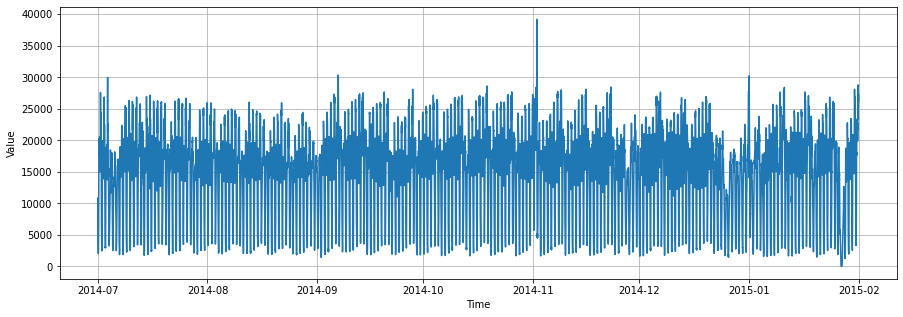

In [17]:
fig = plt.figure(figsize=(15,5))
plot_series(timestamp, series)

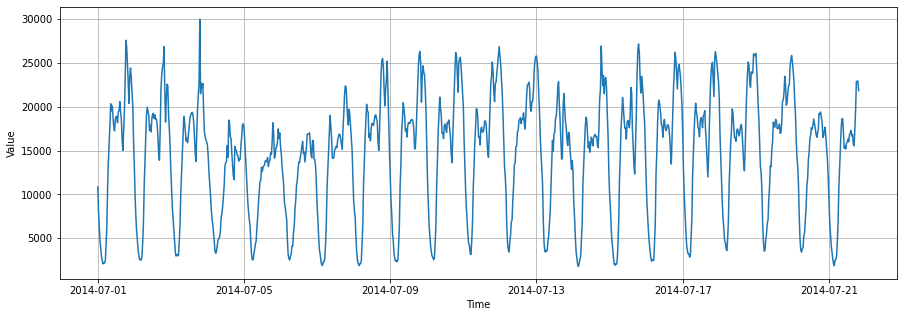

In [18]:
fig = plt.figure(figsize=(15,5))
plot_series(timestamp[0:1000], series[0:1000])

1


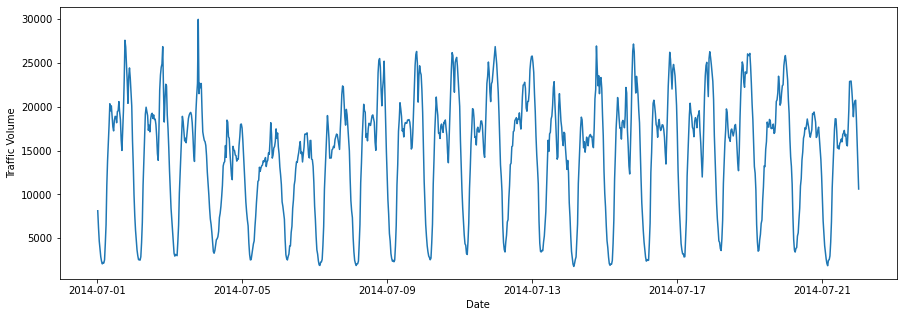

In [19]:
plot_series_by_date(df, '2014-07-01 00:30:00', '2014-07-22 00:30:00')

#### Preprocessing data

In [20]:
#Normalize data, so that all values are between 0 and 1
maximum = series.max()
f = lambda x: x/maximum
series = f(series)
time = df.index.to_numpy()

In [21]:
#Split in train and test data
split_time = 8000
train_series = series[:split_time]
valid_series = series[split_time:]

### With my datagenerator: Single Step Forecasting using stateful LSTM

In [ ]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 1
# split into samples
X_train, y_train = split_sequences(train_series, n_steps_in, n_steps_out, is_stateful_network = True, sequence_to_sequence_RNN= True)
X_valid, y_valid = split_sequences(valid_series, n_steps_in, n_steps_out, is_stateful_network = True, sequence_to_sequence_RNN= True)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (266, 30)
y_train: (266, 30)
X_valid: (77, 30)
y_valid: (77, 30)


In [ ]:
X_train.shape

(266, 30)

In [ ]:
y_train.shape

(266, 30)

In [ ]:
for i in range(1):
  print('X_train: ', X_train[i])
  print('y_train: ', y_train[i])

X_train:  [0.27665383 0.2073373  0.15843049 0.1187846  0.09745644 0.07329643
 0.0604383  0.05265709 0.0566625  0.05505523 0.06416307 0.11133505
 0.16649233 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034
 0.49848203 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095
 0.48238386 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082]
y_train:  [0.2073373  0.15843049 0.1187846  0.09745644 0.07329643 0.0604383
 0.05265709 0.0566625  0.05505523 0.06416307 0.11133505 0.16649233
 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034 0.49848203
 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095 0.48238386
 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082 0.49442559]


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], 1))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (266, 30, 1)
y_train: (266, 30, 1)
X_valid: (77, 30, 1)
y_valid: (77, 30, 1)


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = keras.optimizers.SGD(learning_rate=1e-10, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep.h5', save_best_only=True)
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=100,
                    shuffle=False,
                    batch_size=1,
                    callbacks=[reset_states, model_checkpoint, lr_schedule],
                    validation_data=(X_valid, y_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = keras.optimizers.SGD(learning_rate=3e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep.h5', save_best_only=True)

history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=30,
                    shuffle=False,
                    batch_size=1,
                    callbacks=[reset_states, model_checkpoint],
                    validation_data=(X_valid, y_valid))

Epoch 1/30
266/266 [==============================] - 28s 29ms/step - loss: 0.4319 - mae: 0.7211 - val_loss: 0.0191 - val_mae: 0.1736
Epoch 2/30
266/266 [==============================] - 7s 25ms/step - loss: 0.0080 - mae: 0.0993 - val_loss: 0.0038 - val_mae: 0.0708
Epoch 3/30
266/266 [==============================] - 7s 25ms/step - loss: 0.0042 - mae: 0.0744 - val_loss: 0.0039 - val_mae: 0.0723
Epoch 4/30
266/266 [==============================] - 6s 24ms/step - loss: 0.0041 - mae: 0.0733 - val_loss: 0.0039 - val_mae: 0.0727
Epoch 5/30
266/266 [==============================] - 7s 26ms/step - loss: 0.0041 - mae: 0.0728 - val_loss: 0.0039 - val_mae: 0.0724
Epoch 6/30
266/266 [==============================] - 6s 24ms/step - loss: 0.0040 - mae: 0.0724 - val_loss: 0.0039 - val_mae: 0.0721
Epoch 7/30
266/266 [==============================] - 7s 27ms/step - loss: 0.0040 - mae: 0.0719 - val_loss: 0.0038 - val_mae: 0.0719
Epoch 8/30
266/266 [==============================] - 6s 24ms/step -

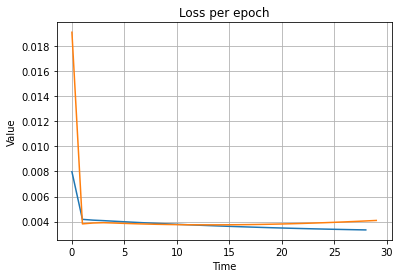

In [ ]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][:]
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

In [ ]:
model = keras.models.load_model("singlevariate_singlestep.h5")

In [ ]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 2s 2s/step


In [ ]:
rnn_forecast.shape

(2320,)

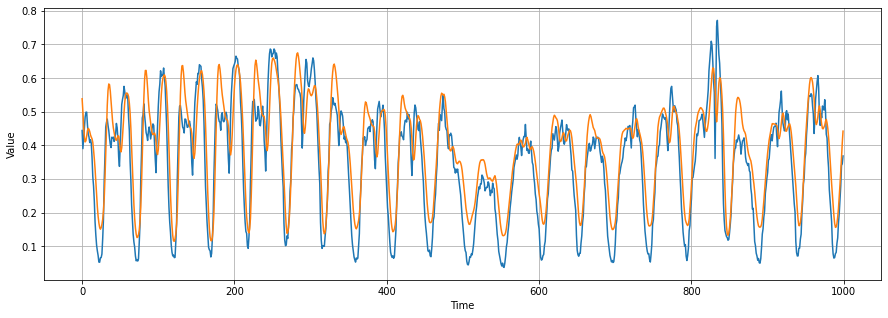

In [ ]:
plt.figure(figsize=(15, 5))
end = 1000
plot_series(range(len(valid_series[0:end])),valid_series[0:end], format='-')
plot_series(range(len(valid_series[0:end])), rnn_forecast[0:end], format='-', )

In [ ]:
keras.metrics.mean_absolute_error(valid_series, rnn_forecast).numpy()

0.071065344

### Single Step Forecasting using stateful, stacked LSTM and sequence to sequence learingn

In [ ]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
keras.backend.clear_session()
window_size = 30
train_set = sequential_window_dataset(train_series, window_size)
val_set = sequential_window_dataset(valid_series, window_size)

In [ ]:
test = train_set.as_numpy_iterator()
for i in range(1):
  elem = test.next()
  print('X', elem[0].shape)
  print('Y', elem[1].shape)
  #print('X', elem[0])
  #print('y: ', elem[1])

X (1, 30, 1)
Y (1, 30, 1)


In [ ]:
n_steps_in = 30
n_steps_out = 1

X_train, y_train = split_sequences(valid_series, n_steps_in, n_steps_out, is_stateful_network = True, sequence_to_sequence_RNN= True)
X_valid, y_valid = split_sequences(train_series, n_steps_in, n_steps_out, is_stateful_network = True, sequence_to_sequence_RNN= True)

In [ ]:
X_train.shape

(77, 30)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = keras.optimizers.SGD(learning_rate=1e-10, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep_stateful.h5', save_best_only=True)

history = model.fit(train_set, 
                    epochs=20,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    validation_data=val_set)

Epoch 1/20
266/266 [==============================] - 12s 33ms/step - loss: 0.3865 - mae: 0.5301 - val_loss: 0.0013 - val_mae: 0.0402
Epoch 2/20
266/266 [==============================] - 7s 25ms/step - loss: 0.0271 - mae: 0.1535 - val_loss: 0.0068 - val_mae: 0.1059
Epoch 3/20
266/266 [==============================] - 6s 22ms/step - loss: 0.0096 - mae: 0.1041 - val_loss: 0.0040 - val_mae: 0.0765
Epoch 4/20
266/266 [==============================] - 6s 22ms/step - loss: 0.0106 - mae: 0.1078 - val_loss: 0.0015 - val_mae: 0.0432
Epoch 5/20
266/266 [==============================] - 7s 27ms/step - loss: 0.0078 - mae: 0.0946 - val_loss: 0.0018 - val_mae: 0.0470
Epoch 6/20
266/266 [==============================] - 7s 25ms/step - loss: 0.0068 - mae: 0.0889 - val_loss: 0.0010 - val_mae: 0.0349
Epoch 7/20
266/266 [==============================] - 6s 22ms/step - loss: 0.0060 - mae: 0.0842 - val_loss: 0.0013 - val_mae: 0.0413
Epoch 8/20
266/266 [==============================] - 6s 22ms/step -

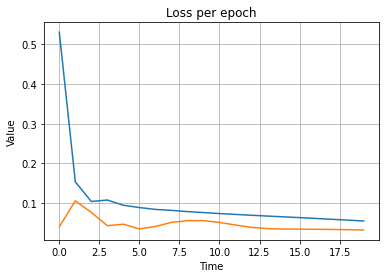

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

In [ ]:
model = keras.models.load_model("singlevariate_singlestep_stateful.h5")

In [ ]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 3s 3s/step


In [ ]:
rnn_forecast.shape

(2320,)

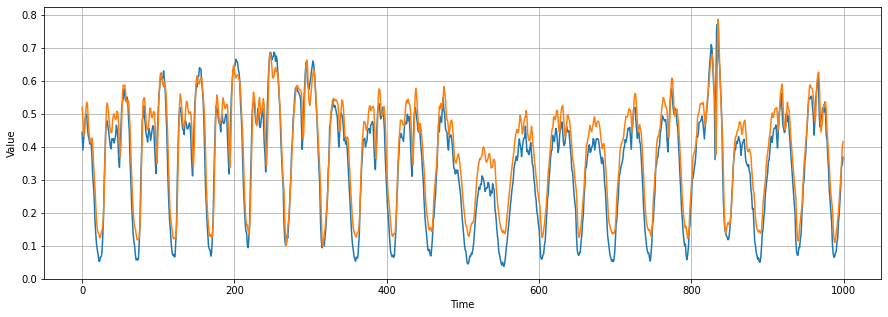

In [ ]:
plt.figure(figsize=(15, 5))
end = 1000
plot_series(range(len(valid_series[0:end])),valid_series[0:end], format='-')
plot_series(range(len(valid_series[0:end])), rnn_forecast[0:end], format='-', )

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.035746504

### Single Step Forecasting using stacked LSTM

#### Data Preparation

In [ ]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 1
if len(valid_series.shape) == 1:
  n_features ==1
else:
  n_features==valid_series.shape[1]
# split into samples
X_train, y_train = split_sequences(train_series, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)

X_train:  (7970, 30)
y_train:  (7970, 1)
X_valid:  (2290, 30)
y_valid:  (2290, 1)


In [ ]:
for i in range(2):
  print('X_train: ', X_train[i])
  print('y_train: ', y_train[i])

X_train:  [0.27665383 0.2073373  0.15843049 0.1187846  0.09745644 0.07329643
 0.0604383  0.05265709 0.0566625  0.05505523 0.06416307 0.11133505
 0.16649233 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034
 0.49848203 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095
 0.48238386 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082]
y_train:  [0.49442559]
X_train:  [0.2073373  0.15843049 0.1187846  0.09745644 0.07329643 0.0604383
 0.05265709 0.0566625  0.05505523 0.06416307 0.11133505 0.16649233
 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034 0.49848203
 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095 0.48238386
 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082 0.49442559]
y_train:  [0.47309743]


#### Building and Training of the Model

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, activation='relu', input_shape=[None, n_features]),
  keras.layers.LSTM(100, activation='relu'),
  keras.layers.Dense(n_steps_out),
  keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(loss=keras.losses.Huber(),
              optimizer= keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep.h5', save_best_only=True)


history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=epochs,
                    batch_size=32,
                    shuffle = True,
                    callbacks=[reset_states, model_checkpoint],
                    validation_data=(X_valid, y_valid))

Epoch 1/10
250/250 [==============================] - 21s 64ms/step - loss: 0.0066 - mae: 0.0876 - val_loss: 0.0030 - val_mae: 0.0609
Epoch 2/10
250/250 [==============================] - 18s 72ms/step - loss: 0.0026 - mae: 0.0550 - val_loss: 0.0023 - val_mae: 0.0526
Epoch 3/10
250/250 [==============================] - 15s 62ms/step - loss: 0.0022 - mae: 0.0506 - val_loss: 0.0022 - val_mae: 0.0507
Epoch 4/10
250/250 [==============================] - 16s 63ms/step - loss: 0.0020 - mae: 0.0483 - val_loss: 0.0019 - val_mae: 0.0471
Epoch 5/10
250/250 [==============================] - 16s 66ms/step - loss: 0.0018 - mae: 0.0454 - val_loss: 0.0019 - val_mae: 0.0489
Epoch 6/10
250/250 [==============================] - 16s 62ms/step - loss: 0.0017 - mae: 0.0439 - val_loss: 0.0016 - val_mae: 0.0435
Epoch 7/10
250/250 [==============================] - 16s 62ms/step - loss: 0.0016 - mae: 0.0422 - val_loss: 0.0015 - val_mae: 0.0422
Epoch 8/10
250/250 [==============================] - 15s 62ms

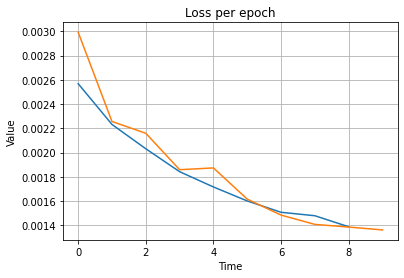

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [ ]:
model = keras.models.load_model("singlevariate_singlestep.h5")

In [ ]:
X, y = split_sequences(series, n_steps_in, n_steps_out)
X = X.reshape(X.shape[0], X.shape[1], n_features)
print('X: ', X.shape)
print('y: ', y.shape)


X:  (10290, 30, 1)
y:  (10290, 1)


In [ ]:
rnn_forecast = model.predict(X)


322/322 [==============================] - 6s 18ms/step


In [ ]:
rnn_forecast = rnn_forecast[split_time - n_steps_in - 1:-1, 0]

In [ ]:
print('Forecast shape: ', rnn_forecast.shape)
print('Series shape: ', valid_series.shape)

Forecast shape:  (2320,)
Series shape:  (2320,)


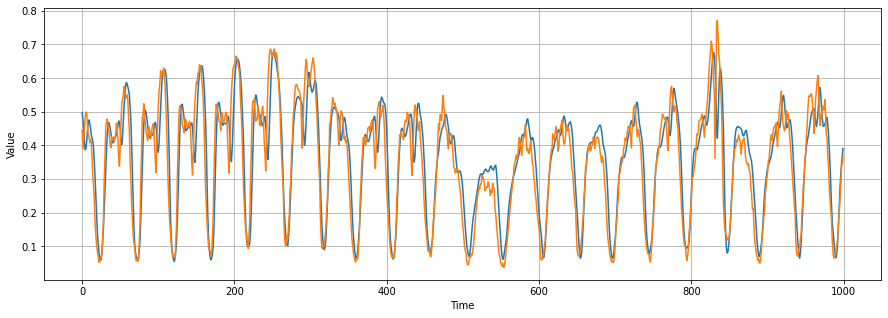

In [ ]:
plt.figure(figsize=(15, 5))
end = 1000
plot_series(range(len(valid_series[0:end])), valid_series[0:end], format='-', )
plot_series(range(len(rnn_forecast[0:end])),rnn_forecast[0:end], format='-')

In [ ]:
keras.metrics.mean_absolute_error(valid_series, rnn_forecast).numpy()

0.054885313

### Multi Step Forecasting using stacked LSTM

#### Data Preparation

In [25]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 60, 48
n_features =1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
X_train, y_train = split_sequences(train_series, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)

X_train:  (7893, 60)
y_train:  (7893, 48)
X_valid:  (2213, 60)
y_valid:  (2213, 48)


In [26]:
for i in range(2):
  print('X_train: ', X_train[i])
  print('y_train: ', y_train[i])

X_train:  [0.27665383 0.2073373  0.15843049 0.1187846  0.09745644 0.07329643
 0.0604383  0.05265709 0.0566625  0.05505523 0.06416307 0.11133505
 0.16649233 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034
 0.49848203 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095
 0.48238386 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082
 0.49442559 0.47309743 0.41401128 0.38301401 0.43888563 0.49812486
 0.58591219 0.7040845  0.68441462 0.63535475 0.58359058 0.52029492
 0.59700998 0.62349159 0.59489247 0.5544557  0.5128964  0.41102635
 0.34109753 0.2537184  0.19315254 0.15095543 0.12296859 0.09271118
 0.07635788 0.06467332 0.06556624 0.06339771 0.07316886 0.11434549]
y_train:  [0.17317652 0.28262367 0.3502564  0.42605301 0.48871087 0.50904406
 0.49753808 0.4845779  0.44164094 0.45676965 0.43709978 0.47424548
 0.4881496  0.49133862 0.47623543 0.48672092 0.47314846 0.47434753
 0.45837692 0.42411409 0.3733449  0.35431283 0.44467689 0.55920096
 0.6029288  0.62535398 0.63492104 0.68556

#### Building and Training of the Model

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint('univariate_multistep_new.h5')
history = model.fit(
                    x=X_train, 
                    y=y_train, epochs=epochs,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    epochs=epochs,
                    shuffle = True,
                    batch_size = 32,
                    validation_data=(X_valid, y_valid)
                    )

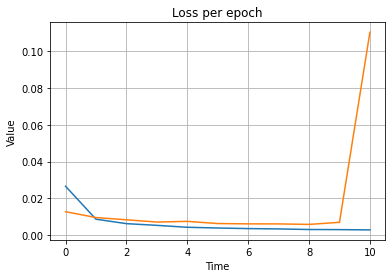

In [ ]:
loss = history.history['loss'][:11]
val_loss = history.history['val_loss'][:11]
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [ ]:
model = keras.models.load_model("singlevariate_multistep.h5")

In [ ]:
rnn_forecast = model.predict(X_valid)
print(rnn_forecast.shape)


70/70 [==============================] - 3s 33ms/step
(2213, 48)


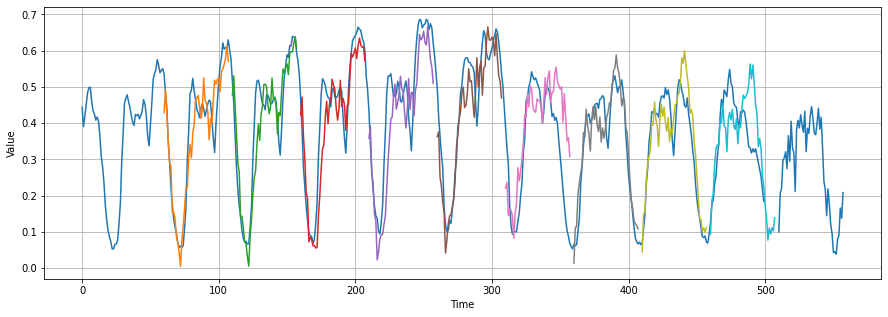

In [ ]:
fig = plt.figure(figsize=(15,5))
end = 1000
plot_series(range(len(valid_series))[0:end], valid_series[0:end])

for index in range(0,end,100):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index])

In [ ]:
print(rnn_forecast.shape)
print(y_valid.shape)

(2213, 48)
(2213, 48)


In [ ]:
keras.metrics.mean_absolute_error(y_valid, rnn_forecast).numpy().mean()

array([0.05291495, 0.05019678, 0.04780483, ..., 0.08639792, 0.08234423,
       0.07079011], dtype=float32)

## Multivariate Time Series

### Preprocessing Data

In [37]:
df = pd.read_csv('wind.csv')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [39]:
df[df['IND'] == 0].head(10)

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5
5,1961-01-06,10.67,0,0.0,0.0,6.5,0.0,1.2,-2.0
6,1961-01-07,9.17,0,1.9,0.0,9.2,1.0,-2.4,-7.1
7,1961-01-08,14.29,0,0.0,0.0,6.6,0.0,3.1,0.0
8,1961-01-09,8.04,0,8.3,0.0,6.8,0.0,2.4,-0.8
9,1961-01-10,11.42,0,0.0,0.0,6.5,0.0,3.0,0.5


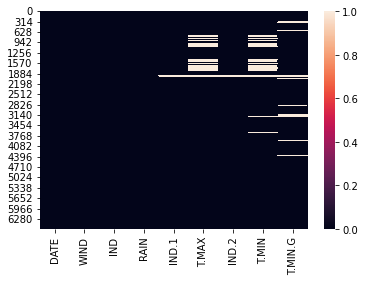

In [40]:
sb.heatmap(df.isnull())

We wil fill all NaN cells with the previous value, since we assume, that wheather only changes slowly.

In [41]:
df = df.fillna(method='ffill');

Since all dates are adjacent, we can drop date column. Also we change datatype of column IND.1 to float 64

In [42]:
df = df.drop(labels=['DATE'], axis=1)

In [43]:
df['IND'] = df['IND'].astype('float64')

Finally put the wind speed column at the last positio and normalize each column with its maximum absolute value.

In [44]:
columns_titles = ['IND', 'RAIN', 'IND.1','T.MAX', 'IND.2', 'T.MIN', 'T.MIN.G', 'WIND']
df=df.reindex(columns=columns_titles)

In [94]:
import math
train_percentage = 0.8
series = df.to_numpy()
splitindex = math.ceil(df.shape[0] * train_percentage)
train_series= series[:splitindex]
valid_series = series[splitindex:]
print('Train data shape: ', train_series.shape)
print('Validation data shape: ', valid_series.shape)

Train data shape:  (5260, 8)
Validation data shape:  (1314, 8)


### Single Time Step Forecasting using stacked LSTM

#### Data Preparation

In [95]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
X_train, y_train = split_sequences(train_series, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)

X_train:  (5230, 30, 8)
y_train:  (5230, 1)
X_valid:  (1284, 30, 8)
y_valid:  (1284, 1)


In [96]:
for i in range(1):
  print('X_train: ', X_train[i])
  print('y_train: ', y_train[i])

X_train:  [[ 0.    0.2   0.    9.5   0.    3.7  -1.   13.67]
 [ 0.    5.1   0.    7.2   0.    4.2   1.1  11.5 ]
 [ 0.    0.4   0.    5.5   0.    0.5  -0.5  11.25]
 [ 0.    0.2   0.    5.6   0.    0.4  -3.2   8.63]
 [ 0.   10.4   0.    7.2   1.   -1.5  -7.5  11.92]
 [ 0.    0.    0.    6.5   0.    1.2  -2.   10.67]
 [ 0.    1.9   0.    9.2   1.   -2.4  -7.1   9.17]
 [ 0.    0.    0.    6.6   0.    3.1   0.   14.29]
 [ 0.    8.3   0.    6.8   0.    2.4  -0.8   8.04]
 [ 0.    0.    0.    6.5   0.    3.    0.5  11.42]
 [ 0.    0.5   0.   10.    1.   -3.1  -7.7   7.54]
 [ 0.    6.    0.   12.2   1.   -3.3  -7.7  15.54]
 [ 0.    0.    0.   13.1   0.    5.5   3.3   4.63]
 [ 0.    0.    0.    5.6   1.   -3.2  -6.1   3.08]
 [ 0.    0.    0.    4.4   1.   -5.   -8.3   2.5 ]
 [ 0.    0.    0.    4.6   1.   -4.2  -8.3   9.25]
 [ 0.    2.    0.    9.3   0.    3.2  -2.7  13.42]
 [ 0.    8.4   0.   10.1   0.    4.3   5.1  17.83]
 [ 0.    0.9   0.    6.6   0.    1.6  -2.    3.71]
 [ 0.   21.5   0.    

#### Building and Training of the Model

In [97]:
n_steps_in = X_train.shape[1]
n_features = X_train.shape[2]
n_steps_out= y_train.shape[1]

# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(keras.layers.LSTM(50, activation='relu'))
model.add(keras.layers.Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics='mae')

model_checkpoint = keras.callbacks.ModelCheckpoint('multivariate_singlestep.h5', save_best_only=True)

# fit model
history = model.fit(x = X_train, 
                    y = y_train,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=32,
                    callbacks = [model_checkpoint, reset_states, early_stoppage],
                    validation_data=(X_valid, y_valid))

Epoch 1/10
164/164 [==============================] - 35s 176ms/step - loss: 94.3726 - mae: 94.8664 - val_loss: 10.0667 - val_mae: 10.5523
Epoch 2/10
164/164 [==============================] - 21s 129ms/step - loss: 5.2269 - mae: 5.7072 - val_loss: 4.2683 - val_mae: 4.7452
Epoch 3/10
164/164 [==============================] - 21s 130ms/step - loss: 3.4610 - mae: 3.9326 - val_loss: 3.2534 - val_mae: 3.7228
Epoch 4/10
164/164 [==============================] - 20s 123ms/step - loss: 3.0783 - mae: 3.5490 - val_loss: 2.9797 - val_mae: 3.4479
Epoch 5/10
164/164 [==============================] - 22s 137ms/step - loss: 2.8856 - mae: 3.3523 - val_loss: 2.8514 - val_mae: 3.3188
Epoch 6/10
164/164 [==============================] - 23s 140ms/step - loss: 2.7921 - mae: 3.2583 - val_loss: 2.7797 - val_mae: 3.2472
Epoch 7/10
164/164 [==============================] - 21s 127ms/step - loss: 2.7390 - mae: 3.2051 - val_loss: 2.7209 - val_mae: 3.1858
Epoch 8/10
164/164 [==============================]

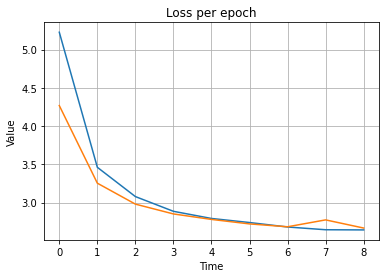

In [98]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [99]:
model = keras.models.load_model('multivariate_singlestep.h5')

In [100]:
X, y = split_sequences(series, n_steps_in, 1)
#X = X.reshape(X.shape[0], X.shape[1], n_features)
print('X: ', X.shape)
print('y: ', y.shape)


X:  (6544, 30, 8)
y:  (6544, 1)


In [102]:
rnn_forecast = model.predict(X)

205/205 [==============================] - 2s 11ms/step


In [106]:
forecast = model.predict(X_valid)
forecast = forecast.reshape(-1)

41/41 [==============================] - 0s 11ms/step


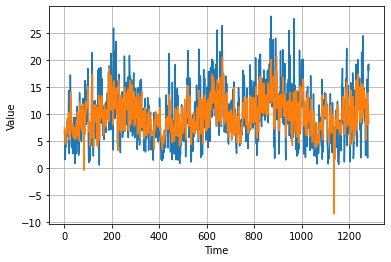

In [107]:
plot_series(range(len(y_valid)), y_valid)
plot_series(range(len(forecast)), forecast)

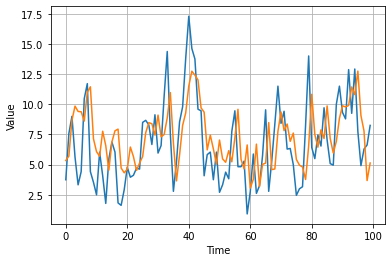

In [66]:
plot_series(range(len(y_valid))[0:100], y_valid[0:100])
plot_series(range(len(forecast))[0:100], forecast[0:100])

In [110]:
#rnn_forecast = rnn_forecast[split_time - n_steps_in - 1:-1, 0]

In [111]:
#plt.figure(figsize=(15, 5))
##end = 1000
#plot_series(range(len(valid_series[0:end])), valid_series[0:end][-1], format='-', )
#plot_series(range(len(rnn_forecast[0:end])),rnn_forecast[0:end], format='-')

### Multi Step Forecasting

#### Data Preparation

In [112]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 7
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
X_train, y_train = split_sequences(train_series, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequences(valid_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)

X_train:  (5224, 30, 8)
y_train:  (5224, 7)
X_valid:  (1278, 30, 8)
y_valid:  (1278, 7)


In [113]:
for i in range(1):
  print('X_train: ', X_train[i])
  print('y_train: ', y_train[i])

X_train:  [[ 0.    0.2   0.    9.5   0.    3.7  -1.   13.67]
 [ 0.    5.1   0.    7.2   0.    4.2   1.1  11.5 ]
 [ 0.    0.4   0.    5.5   0.    0.5  -0.5  11.25]
 [ 0.    0.2   0.    5.6   0.    0.4  -3.2   8.63]
 [ 0.   10.4   0.    7.2   1.   -1.5  -7.5  11.92]
 [ 0.    0.    0.    6.5   0.    1.2  -2.   10.67]
 [ 0.    1.9   0.    9.2   1.   -2.4  -7.1   9.17]
 [ 0.    0.    0.    6.6   0.    3.1   0.   14.29]
 [ 0.    8.3   0.    6.8   0.    2.4  -0.8   8.04]
 [ 0.    0.    0.    6.5   0.    3.    0.5  11.42]
 [ 0.    0.5   0.   10.    1.   -3.1  -7.7   7.54]
 [ 0.    6.    0.   12.2   1.   -3.3  -7.7  15.54]
 [ 0.    0.    0.   13.1   0.    5.5   3.3   4.63]
 [ 0.    0.    0.    5.6   1.   -3.2  -6.1   3.08]
 [ 0.    0.    0.    4.4   1.   -5.   -8.3   2.5 ]
 [ 0.    0.    0.    4.6   1.   -4.2  -8.3   9.25]
 [ 0.    2.    0.    9.3   0.    3.2  -2.7  13.42]
 [ 0.    8.4   0.   10.1   0.    4.3   5.1  17.83]
 [ 0.    0.9   0.    6.6   0.    1.6  -2.    3.71]
 [ 0.   21.5   0.    

#### Building and Training of the Model

In [114]:
n_steps_in = X_train.shape[1]
n_features = X_train.shape[2]
n_steps_out= y_train.shape[1]

# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(keras.layers.LSTM(50, activation='relu'))
model.add(keras.layers.Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics='mae')

model_checkpoint = keras.callbacks.ModelCheckpoint('multivariate_multistep.h5', save_best_only=True)

# fit model
history = model.fit(x = X_train, 
                    y = y_train,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=32,
                    callbacks = [model_checkpoint, reset_states, early_stoppage],
                    validation_data=(X_valid, y_valid))

Epoch 1/10
164/164 [==============================] - 27s 137ms/step - loss: 22.2033 - mae: 22.6846 - val_loss: 3.4155 - val_mae: 3.8893
Epoch 2/10
164/164 [==============================] - 21s 130ms/step - loss: 3.4079 - mae: 3.8806 - val_loss: 3.3490 - val_mae: 3.8213
Epoch 3/10
164/164 [==============================] - 20s 125ms/step - loss: 3.3538 - mae: 3.8264 - val_loss: 3.3227 - val_mae: 3.7962
Epoch 4/10
164/164 [==============================] - 23s 138ms/step - loss: 3.3170 - mae: 3.7888 - val_loss: 3.2614 - val_mae: 3.7344
Epoch 5/10
164/164 [==============================] - 27s 163ms/step - loss: 3.2733 - mae: 3.7456 - val_loss: 3.2230 - val_mae: 3.6949
Epoch 6/10
164/164 [==============================] - 31s 187ms/step - loss: 3.2297 - mae: 3.7014 - val_loss: 3.2399 - val_mae: 3.7111
Epoch 7/10
164/164 [==============================] - 20s 122ms/step - loss: 3.1992 - mae: 3.6710 - val_loss: 3.2100 - val_mae: 3.6814
Epoch 8/10
164/164 [==============================] -

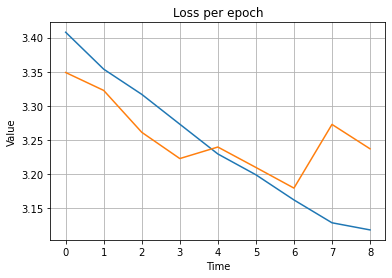

In [115]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [117]:
model = keras.models.load_model("multivariate_multistep.h5")

In [118]:
rnn_forecast = model.predict(X_valid)
print(rnn_forecast.shape)


40/40 [==============================] - 1s 12ms/step
(1278, 7)


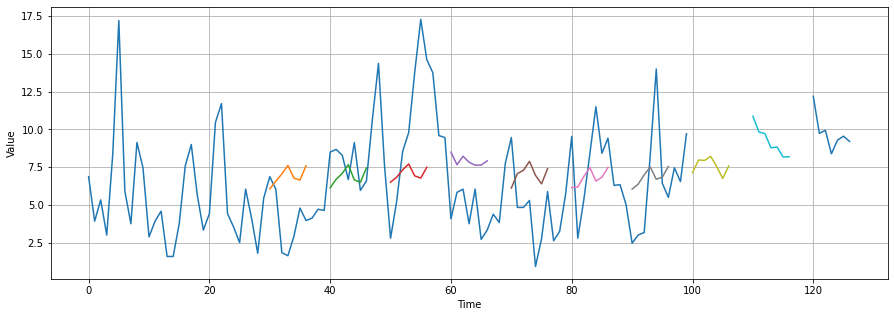

In [127]:
fig = plt.figure(figsize=(15,5))
end = 100
plot_series(range(len(valid_series))[0:end], valid_series[0:end,-1])

for index in range(0,end,10):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index])

#### Thoughts for paper

* Wind difficult to predict, very volatil, complex wheather models are necessary, got not enaugh data
* Wind dataset: no pattern, so use less units in LSTM, compare it with taxi dataset units


In [ ]:
forecast = model.predict(valid_data.reshape((-1, n_steps_in, n_features)))